# Introduction to DBnomics in Python

This tutorial will guide through the process of writing visualizations of [time series](https://en.wikipedia.org/wiki/Time_series).
We will explain how to obtain data from [DBnomics](https://next.nomics.world/), and how to create a chart.

We will use well-known Python packages to achieve our goal, like [Pandas](http://pandas.pydata.org/) to represent tabular data, and [Altair](https://altair-viz.github.io/) to create the charts.

We will also use the `dbnomics` Python package to obtain data from the DBnomics Web API.

First, let's import those libraries:

In [1]:
import pandas as pd
from altair import Chart, Scale, Y

from dbnomics import fetch_series, fetch_series_by_ids, fetch_series_by_dimensions, fetch_series_by_url

Note: in this notebook we are going to follow the conventions of the Scientific Python community. In particular, the `df` shortcut for `DataFrame`.

# Fetch one time series by its code

First, let's assume that we know which series we want to download. A series is defined by those three values: `(provider code, dataset code, series code)`. We can use the `fetch_series` function, previously imported from the `dbnomics` Python package.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://next.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://next.nomics.world/AMECO):

In [2]:
df1 = fetch_series('AMECO', 'ZUTN', 'EA19.1.0.0.0.ZUTN')

The returned data is stored in the `df1` variable. Its type is a [Pandas](http://pandas.pydata.org/) [`DataFrame`](https://pandas.pydata.org/pandas-docs/stable/dsintro.html#dataframe).

Now let's display the first rows of this `DataFrame` by using the `head` method, each row representing an observation of the time series:

In [3]:
df1.head()

,Country,Frequency,Unit,code,freq,geo,name,period,unit,value,dataset_code,dataset_name
0,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1960,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
1,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1961,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
2,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1962,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
3,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1963,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
4,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1964,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...


To plot the `DataFrame`, we need to:

- clean the missing values, i.e. `NA`, `None` or other values, depending on the provider,
- convert the "value" column to `float`.

Note: DBnomics will define a unified `NA` value for missing values quite soon.


For example, the following `clean_dataframe` helper function:

In [4]:
def clean_dataframe(df):
    clean_df = df.query("value != 'NA'").query("value != 'None'")
    clean_df.value = pd.to_numeric(clean_df.value)
    return clean_df

Clean the previously downloaded `df1` `DataFrame`:

In [5]:
df1_clean = clean_dataframe(df1)
df1_clean.head()

,Country,Frequency,Unit,code,freq,geo,name,period,unit,value,dataset_code,dataset_name
38,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1998,percentage-of-active-population,10.4,ZUTN,Unemployment rate: total :- Member States: def...
39,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1999,percentage-of-active-population,9.7,ZUTN,Unemployment rate: total :- Member States: def...
40,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,2000,percentage-of-active-population,8.9,ZUTN,Unemployment rate: total :- Member States: def...
41,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,2001,percentage-of-active-population,8.3,ZUTN,Unemployment rate: total :- Member States: def...
42,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,2002,percentage-of-active-population,8.6,ZUTN,Unemployment rate: total :- Member States: def...


Here we use the [Altair](https://altair-viz.github.io/) library to render charts, but you can use any other one like matplotlib, bqplot, plotly, etc.

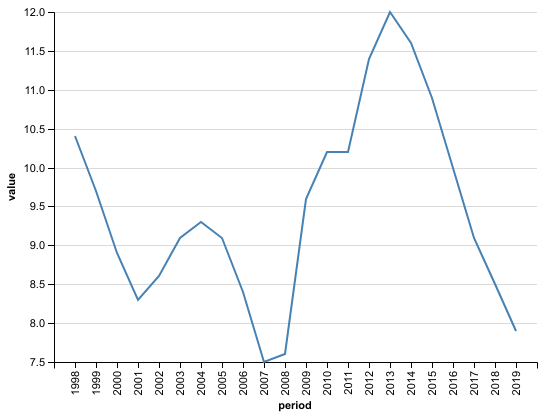

In [6]:
chart = Chart(df1_clean).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
)
chart

# Fetch two time series by their codes

Again, let's assume that we know which series we want to download. We can reuse the `fetch_series_by_ids` function, this time giving two series codes.

For example, to fetch the time series `EA19.1.0.0.0.ZUTN` and `DNK.1.0.0.0.ZUTN` from the ["Unemployment rate" [ZUTN] dataset](https://next.nomics.world/AMECO/ZUTN) belonging to the [AMECO provider](https://next.nomics.world/AMECO):

In [7]:
df2 = fetch_series_by_ids([
    ('AMECO', 'ZUTN', 'EA19.1.0.0.0.ZUTN'),
    ('AMECO', 'ZUTN', 'DNK.1.0.0.0.ZUTN'),
])
df2.head()

,Country,Frequency,Unit,code,freq,geo,name,period,unit,value,dataset_code,dataset_name
0,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1960,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
1,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1961,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
2,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1962,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
3,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1963,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...
4,Euro area,Annually,(Percentage of active population),EA19.1.0.0.0.ZUTN,a,ea19,Euro area,1964,percentage-of-active-population,NA,ZUTN,Unemployment rate: total :- Member States: def...


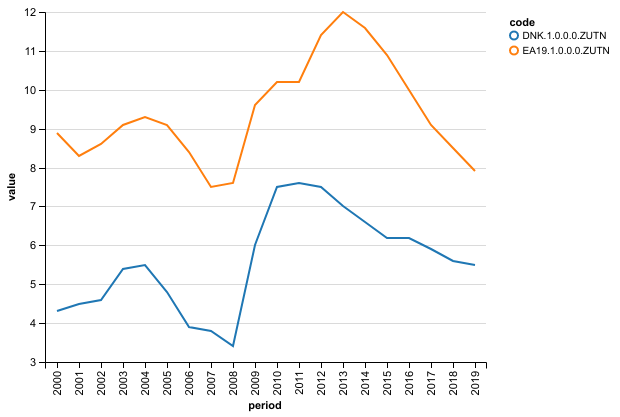

In [8]:
range_df = clean_dataframe(df2).query("period >= '2000'")
chart = Chart(range_df).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='code',
)
chart

## Fetch time series by their dimensions

When you don't know the codes of the series, you can give a `dict` of dimensions to the `fetch_series_by_dimensions` function, and it will return a `DataFrame` containing all the matching series. Here you still must know the provider code, the dataset code, and the codes of the dimensions.

For example, to fetch:
- many series
- from the ["Doing Business" [DB]](https://next.nomics.world/world-bank/DB) dataset of the [World Bank](https://next.nomics.world/world-bank) provider
- searching for time series about France, Italy and Spain (`country` dimension)
- and searching for the indicator "Procedures required to start a business - Women (number)" (`indicator` dimension):

In [9]:
df3 = fetch_series_by_dimensions(
    provider_code="world-bank",
    dataset_code="DB",
    dimensions={
        "country": ["FR", "IT", "ES"],
        "indicator": ["IC.REG.PROC.WOMEN"],
    },
)
df3

,code,country,country_label,indicator,indicator_label,period,value,dataset_code,dataset_name
0,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2003,8,DB,Doing Business
1,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2004,5,DB,Doing Business
2,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2005,5,DB,Doing Business
3,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2006,5,DB,Doing Business
4,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2007,5,DB,Doing Business
5,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2008,5,DB,Doing Business
6,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2009,5,DB,Doing Business
7,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2010,5,DB,Doing Business
8,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2011,5,DB,Doing Business
9,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2012,5,DB,Doing Business


To know the codes of the time series you got:

In [10]:
df3.code.unique()

array(['IC.REG.PROC.WOMEN-FR', 'IC.REG.PROC.WOMEN-IT',
       'IC.REG.PROC.WOMEN-ES'], dtype=object)

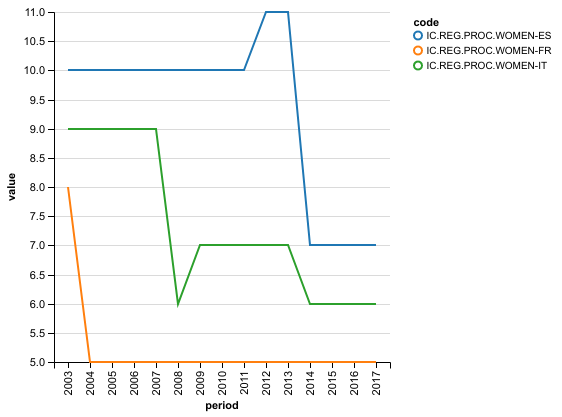

In [11]:
chart = Chart(clean_dataframe(df3)).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='code',
)
chart

## Fetch time series found on the web site

When you don't know the codes of the dimensions, provider, dataset or series, you can:

- go to the page of a dataset on DBnomics website, for example [Doing Business](https://next.nomics.world/world-bank/DB),
- select some dimensions by using the input widgets of the left column,
- copy the "API link" URL (at the right of the "reset filters" button),
- use the `fetch_series_by_url` function such as below.

In [12]:
df4 = fetch_series_by_url("https://api.next.nomics.world/series?dimensions=%7B%22country%22%3A%5B%22FR%22%2C%22IT%22%2C%22ES%22%5D%2C%22indicator%22%3A%5B%22IC.REG.PROC.WOMEN%22%5D%7D&provider_code=world-bank&dataset_code=DB")
df4.head()

,code,country,country_label,indicator,indicator_label,period,value,dataset_code,dataset_name
0,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2003,8,DB,Doing Business
1,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2004,5,DB,Doing Business
2,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2005,5,DB,Doing Business
3,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2006,5,DB,Doing Business
4,IC.REG.PROC.WOMEN-FR,FR,France,IC.REG.PROC.WOMEN,Procedures required to start a business - Wome...,2007,5,DB,Doing Business


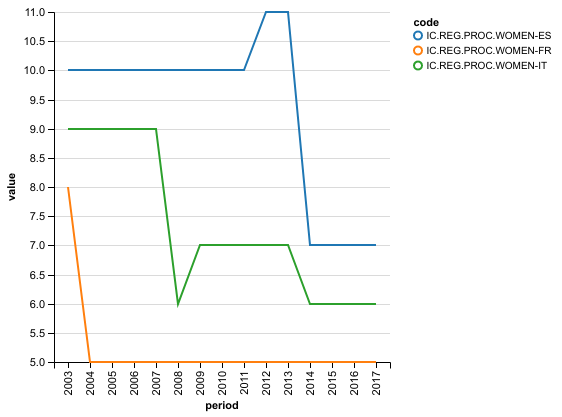

In [13]:
chart = Chart(clean_dataframe(df4)).mark_line().encode(
    x='period',
    y=Y('value', scale=Scale(zero=False)),
    color='code',
)
chart

The chart is exactly the same than the previous one, generated by the `fetch_series_by_dimensions` function.

## Fetch time series from the cart

On the [cart page](https://next.nomics.world/cart) of DBnomics website, you see an "API link" you can copy-paste as an argument of the `fetch_series_by_url` function.

Please note that when you update your cart, you have to copy this link again, because the link itself contains the IDs of the series in the cart.

In [18]:
cart_df = fetch_series_by_url("https://api.next.nomics.world/series?series_ids=bank-of-england%2F8745%2FLPMB23A%2Cbank-of-england%2F8745%2FLPMB26A")
cart_df.head()

,code,name,period,value,dataset_code,dataset_name
0,LPMB23A,Monthly number of other specialist lenders' st...,1999-01-31,937,8745,Monthly lending secured on dwellings: approvals
1,LPMB23A,Monthly number of other specialist lenders' st...,1999-02-28,1571,8745,Monthly lending secured on dwellings: approvals
2,LPMB23A,Monthly number of other specialist lenders' st...,1999-03-31,2094,8745,Monthly lending secured on dwellings: approvals
3,LPMB23A,Monthly number of other specialist lenders' st...,1999-04-30,1859,8745,Monthly lending secured on dwellings: approvals
4,LPMB23A,Monthly number of other specialist lenders' st...,1999-05-31,1865,8745,Monthly lending secured on dwellings: approvals
